In [18]:
from abinitio_tm import abinitio 
import numpy
from msprime_models import * 
# from abinitio_tm import scaled_time_intervals
# from msprime_utils import scaled_time_intervals, get_het, round_coal_times, tm_counts, get_coal_data, round_bin_coal_data, normalise
from msprime_utils import *
from heatmaps_generate import * 
from vcf_mhs import *
import argparse

In [19]:
# scaled_time_intervals 

mu = 2e-08
alpha = 0.1
N_0 = 10000 # TODO, use sim
Tmax = 15
N_T = 50
T = [0]
for i in range(0,N_T): # TODO: should T have upper interval
        T.append( alpha*math.exp( (i/N_T)*math.log(1 + Tmax/alpha) - 1))
T_np = np.array(T) # convert to numpy
# scale these to generations with *2*N_0, as per Schiffels' instruction
T_scaled_np = T_np * 2 * N_0

print(f'T_np is {T_np}')
print(f'T_scaled_np is {T_scaled_np}')

T_np is [0.         0.03678794 0.04067102 0.04496396 0.04971004 0.05495708
 0.06075796 0.06717115 0.07426126 0.08209975 0.09076562 0.10034619
 0.11093803 0.12264786 0.1355937  0.14990602 0.16572904 0.18322222
 0.20256186 0.22394286 0.24758068 0.27371355 0.30260482 0.33454564
 0.36985791 0.4088975  0.45205783 0.49977385 0.55252645 0.61084723
 0.67532394 0.74660636 0.82541285 0.91253759 1.00885861 1.11534659
 1.23307468 1.36322933 1.50712217 1.66620333 1.84207597 2.03651248
 2.25147233 2.48912183 2.75185593 3.04232238 3.36344841 3.71847024
 4.11096566 4.54489012 5.02461657]
T_scaled_np is [     0.            735.75888234    813.42038634    899.27928944
    994.20085113   1099.14166153   1215.15928169   1343.42290131
   1485.22512147   1641.9949811    1815.31235837   2006.92389221
   2218.76058439   2452.95725959   2711.87407948   2998.12032771
   3314.58070543   3664.44440247   4051.23723698   4478.85718752
   4951.61367571   5474.27099526   6052.09632498   6690.91280986
   7397.15824489

In [57]:
# structure: parameters

def structure_parameters(n=2,N=10000,m=5e-04,mew=2e-08):
    
# n: number of demes
# N: constant size of each island
# m: Nm is the number of genes in each island every generation. So let's say Nm = 10, then m = 10/N = 0.001
# mew: mutation raite

    # then population mutation rate is 2*N*n*mu
    theta = 2*N*n*mu

    M = 2*N*m
    
    # so, by Mazet (2016):
    gamma = M/(n-1)

    # discriminant of theta^ + theta(1-n*gamma) + gamma is:
    delta = (1+n*gamma)**2 - 4*gamma

    # alpha 
    alpha = 0.5*(1+n*gamma + np.sqrt(delta))

    # beta is
    beta = 0.5*(1+n*gamma - np.sqrt(delta))

    # then a and c
    a = (gamma - alpha)/(beta-alpha)
    c = gamma/(beta - alpha)

    print(f'a, c, alpha, beta, gamma is {a,c,alpha,beta,gamma}')
    print(f'theta, Nn (total pop size) is {theta,N*n}')
    
    return a, c, alpha, beta, gamma

## F_T2
def F_T2(x,n,N,m,mew):
    a,c,alpha,beta,gamma = structure_parameters(n,N,m,mew)
    F = (1/n)*(
        (-a/alpha)*np.exp(-alpha*(x)) -((1-a)/beta)*np.exp(-beta*(x)) - (c/alpha)*np.exp(-alpha*(x)) + (c/beta)*np.exp(-beta*(x))
        -(-a/alpha - (1-a)/beta -c/alpha + c/beta))
    return F

def f_T2(x,n,N,m,mew):
    a,c,alpha,beta,gamma = structure_parameters(n,N,m,mew)
    same_deme = a*np.exp(-alpha*(x)) + (1-a)*np.exp(-beta*(x))
    diff_deme = c*np.exp(-alpha*(x)) - c*np.exp(-beta*(x))
    f = (1/n)*(same_deme+diff_deme) # TODO maybe do that division thing here
    return f
    
## time intervals 
spacing = 100
time_intervals = np.arange(min_time,max_time,spacing)
# (len(time_intervals)/15)
N_e = 1e+04
n = 2
N = 0.5e+04
m = 0.001
mew = 2e-08

In [1]:

# for i in range(N_T):
i = 0
min_time = T_scaled_np[i]
max_time = T_scaled_np[i+1]
divisions = (max_time - min_time)/spacing
time_intervals0 = (np.arange(min_time,max_time,divisions))/N_e
f_0 = f_T2(time_intervals,n,N,m,mew)/(len(time_intervals)/15) # TODO discretise n, N m and mew
F_0 = F_T2(time_intervals,n,N,m,mew)
print('for i = {},\nmin time is {}\nmax time is {}\ntime_intervals are \n{}'.format(i,min_time,max_time,time_intervals))
print('f_0 is {}'.format(f_0))
print('F_0 is {}'.format(F_0))

iCR0_obs = [(1-F_0[i])/(2*f_0[i]) for i in range(len(f_0)) ] # this returns the CR of the history, defined as (1-F_T2(t))/f_T2(t)
iCR0 = [(1-f_T2(time_intervals0,n,N,m,mew))/(f_T2(time_intervals0,n,N,m,mew))]

plt.plot(time_intervals0,f_0)
plt.title('f_0')
plt.show()
plt.plot(time_intervals0,F_0)
plt.title('F_0')
plt.show()
plt.plot(time_intervals0,iCR0_obs)
plt.title('iCR0_obs')
plt.show()
plt.plot(time_intervals0,iCR0[0])
plt.title('iCR0')
plt.show()


i = 1


min_time = T_scaled_np[i]
max_time = T_scaled_np[i+1]
divisions = (max_time - min_time)/spacing
time_intervals1 = (np.arange(min_time,max_time,divisions))/N_e - min_time/N_e
print('for i = {},\nmin time is {}\nmax time is {}\ntime_intervals are \n{}'.format(i,min_time,max_time,time_intervals))
f_1 = (1-F_0[-1]) * f_T2(time_intervals1,n,N,m,mew)
F_1 = F_0[-1] + (1-F_0[-1])*F_T2(time_intervals1,n,N,m,mew)
iCR1_obs = [(1-F_1[i])/(2*f_1[i]) for i in range(len(f_1)) ] # this returns the CR of the history, defined as (1-F_T2(t))/f_T2(t)
iCR1 = [(1-f_T2(time_intervals1,n,N,m,mew))/(f_T2(time_intervals1,n,N,m,mew))]

plt.plot(time_intervals1 +  min_time/N_e,f_1/(len(time_intervals)/15))
plt.title('f_1')
plt.show()
plt.plot(time_intervals1 +  min_time/N_e,F_1)
plt.title('F_1')
plt.show()

plt.plot(time_intervals0,f_0)
plt.plot(time_intervals1 +  min_time/N_e,f_1)

plt.show()
plt.plot(time_intervals0,F_0)
plt.plot(time_intervals1 +  min_time/N_e,F_1)
plt.show()

plt.plot(time_intervals1,iCR1_obs)
plt.title('iCR1_obs')
plt.show()
plt.plot(time_intervals1,iCR1[0])
plt.title('iCR1')
plt.show()

plt.plot(time_intervals0)
plt.plot(time_intervals1+min_time/N_e)
plt.title('time intervals')
plt.show()

NameError: name 'T_scaled_np' is not defined

In [82]:
iCR0[0]

array([1.        , 1.00146667, 1.00292372, 1.00437128, 1.00580947,
       1.00723842, 1.00865825, 1.01006908, 1.01147104, 1.01286422,
       1.01424877, 1.01562478, 1.01699237, 1.01835166, 1.01970276,
       1.02104577, 1.02238081, 1.02370799, 1.0250274 , 1.02633916,
       1.02764337, 1.02894012, 1.03022953, 1.0315117 , 1.03278671,
       1.03405468, 1.03531569, 1.03656984, 1.03781722, 1.03905794,
       1.04029208, 1.04151973, 1.04274098, 1.04395592, 1.04516463,
       1.04636722, 1.04756375, 1.04875432, 1.049939  , 1.05111789,
       1.05229105, 1.05345858, 1.05462055, 1.05577704, 1.05692813,
       1.05807389, 1.05921439, 1.06034972, 1.06147995, 1.06260515,
       1.06372539, 1.06484074, 1.06595127, 1.06705705, 1.06815815,
       1.06925464, 1.07034658, 1.07143404, 1.07251708, 1.07359576,
       1.07467016, 1.07574033, 1.07680633, 1.07786822, 1.07892607,
       1.07997993, 1.08102987, 1.08207593, 1.08311817, 1.08415666,
       1.08519144, 1.08622258, 1.08725012, 1.08827412, 1.08929

Calculating theoretical TM probablities.
expected_times conforms with T.
Finished.


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


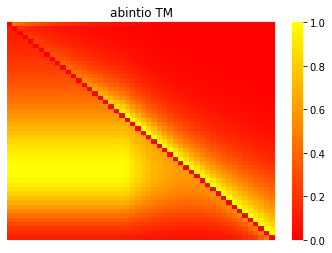

In [41]:
pop_size = [10000 for i in range(0,50)] # set array of population sizes (for the lambda array)
ab_tm_nd, ab_tm = abinitio(pop_size,T_np,N_0,N_T) # generate theoretical probabilities of this matrix 
heatmaps_seq(normalise(ab_tm_nd,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap



In [42]:
def const_pop(seq_length):
    N_A = 10000
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=2, initial_size=N_A,growth_rate=0)
    ]
    migration_matrix = [
        [0],
        ]
    demographic_events = [
    ]
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,
        migration_matrix=migration_matrix,
        demographic_events=demographic_events)
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           migration_matrix=migration_matrix,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-8,mutation_rate=2e-8)
    return sim

In [43]:
parser = argparse.ArgumentParser()
parser.add_argument("model",help="Specify the model to be used, as defined in msprime_models.")
parser.add_argument("--print",help="Print the DemographicDebugger (from msprime) and the number of segratating sites",action="store_true")
parser.add_argument("--tree",help="Draw trees and info per segment",action="store_true")
parser.add_argument("-bin","--bin_length",help="The length (in bases) of the how wide you want each bin. (Default is 100)",default=100,type=int)
parser.add_argument("-N_T","--Number_of_states",help="The number of states you want, for the time intervals (Default is 50)",default=50,type=int)
args = parser.parse_args("m0001".split())

In [ ]:
sim = const_pop(150e+06)


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


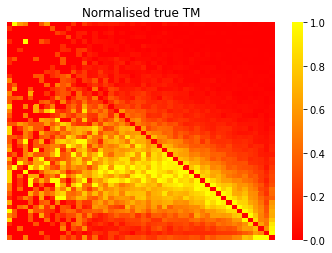

In [48]:
tmrca_data = get_coal_data(sim, args) # get true coalescent 
coal_times = round_bin_coal_data(sim.sequence_length,tmrca_data, args) # partition coalescent data into bins  
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals = round_coal_times(coal_times,T_scaled_np,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm = tm_counts(coal_times_intervals,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd = np.copy(tm)
tm_nd[range(0,len(tm)),range(0,len(tm))] = 0
tm_nd_norm = normalise(tm_nd,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

heatmaps_seq(normalise(tm_nd,'colmax'),title='Normalised true TM') # show heatmap


array([     0.        ,    735.75888234,    813.42038634,    899.27928944,
          994.20085113,   1099.14166153,   1215.15928169,   1343.42290131,
         1485.22512147,   1641.9949811 ,   1815.31235837,   2006.92389221,
         2218.76058439,   2452.95725959,   2711.87407948,   2998.12032771,
         3314.58070543,   3664.44440247,   4051.23723698,   4478.85718752,
         4951.61367571,   5474.27099526,   6052.09632498,   6690.91280986,
         7397.15824489,   8177.94995315,   9041.15651202,   9995.47705026,
        11050.52891512,  12216.94459303,  13506.47886048,  14932.12724502,
        16508.25699021,  18250.75184418,  20177.17213123,  22306.93171926,
        24661.49366677,  27264.58652092,  30142.4434465 ,  33324.06659564,
        36841.5193825 ,  40730.24960852,  45029.44669433,  49782.43661864,
        55037.11854405,  60846.44753001,  67268.9681975 ,  74369.40472367,
        82219.31311201,  90897.80231171, 100492.3314531 ])

## Num Replicates with T2 times